In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.plot import draw

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

In [2]:
settings = "mean_absolute"

## Dataframe

In [3]:
df = pd.read_csv(
    "~/ceph/lola/results/rayleigh_benard/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "relative",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "wasserstein",
        "emd",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "rayleigh",
        "prandtl",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

if "relative" in settings:
    df = df[df["relative"]]
elif "absolute" in settings:
    df = df[~df["relative"]]

df = df[df["time"] > 0]
df = df[df["start"] == 16]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3],
        "std_global": [0.25, 0.15, 0.20, 0.20],
    })
)


def horizon(t):
    if t < 20:
        return "01:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:180"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["spread_skill"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df["method"] = df["method"].replace("surrogate", "neural solver")
df.loc[df["method"] == "neural solver", "spread_skill"] = 0.0

In [4]:
def aggregate(x):
    if "mean" in settings:
        return np.mean(x)
    elif "median" in settings:
        return np.median(x)

## Plots

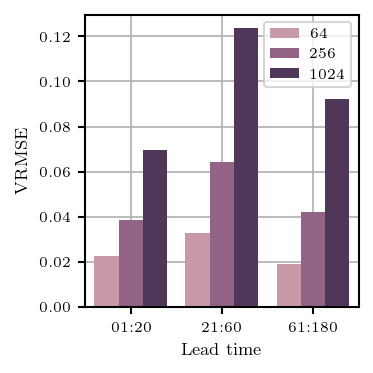

In [5]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(2.4, 2.4))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=aggregate,
    errorbar=None,
    palette=sb.cubehelix_palette(4, dark=0.25)[1:],
)

ax.grid()
ax.get_legend().set_title(None)

ax.set_xlabel("Lead time")
ax.set_ylabel("VRMSE")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / f"rb_ae_{settings}.pdf", dpi=300, transparent=True)

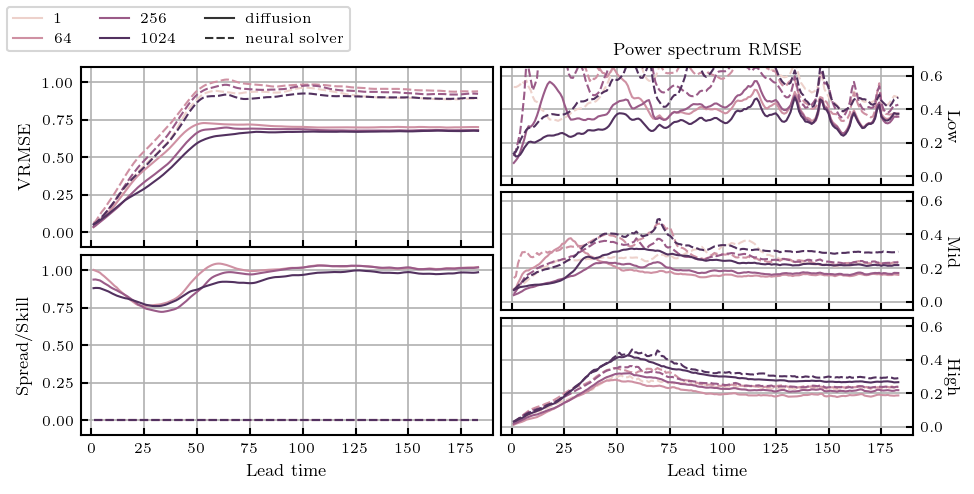

In [6]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "spread_skill"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.cubehelix_palette(4, dark=0.25),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 190)
    ax.set_ylim(-0.1, 1.1)

    if metric == "spread_skill":
        ax.set_ylabel("Spread/Skill")
    else:
        ax.set_ylabel(metric)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.cubehelix_palette(4, dark=0.25),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 190)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=3)

plt.savefig(outdir / f"rb_mosaic_{settings}.pdf", dpi=300, transparent=True)

## Tables

In [7]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                    01:20  21:60 61:180
method        compression                     
autoencoder   64           0.023  0.033  0.019
              256          0.039  0.064  0.042
              1024         0.070  0.124  0.092
diffusion     64           0.171  0.582  0.704
              256          0.141  0.509  0.683
              1024         0.146  0.457  0.670
neural solver 1            0.185  0.681  0.918
              64           0.244  0.761  0.968
              256          0.197  0.716  0.945
              1024         0.195  0.665  0.903

In [8]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                01:20  21:60 61:180
method        context                     
diffusion     1        0.152  0.510  0.683
              2        0.150  0.511  0.685
              3        0.157  0.527  0.689
neural solver 1        0.208  0.705  0.932
              2        0.209  0.708  0.943
              3        0.220  0.728  0.940

In [9]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                        01:20  21:60 61:180      01:20  21:60 61:180   
method        compression                                                     
autoencoder   64               0.043  0.004  0.001      0.011  0.013  0.012   
              256              0.061  0.011  0.004      0.028  0.080  0.075   
              1024             0.121  0.033  0.018      0.063  0.186  0.197   
diffusion     64               1.751  0.850  0.386      0.197  0.266  0.159   
              256              0.328  0.399  0.396      0.084  0.195  0.177   
              1024             0.193  0.292  0.344      0.095  0.243  0.240   
neural solver 1                0.467  0.520  0.650      0.151  0.255  0.264   
              64               3.625  0.915  0.566      0.268  0.351  0.275   
              256              0.575  0.675  0.526      0.165  0.317  0.264   
              1024             0.285  0.496  0.560      0.152  0.338  0.321   

                          rmse_p_high                
horizon                         01:20  21:60 61:180  
method        compression                            
autoencoder   64                0.026  0.159  0.148  
              256               0.050  0.220  0.212  
              1024              0.076  0.294  0.294  
diffusion     64                0.054  0.220  0.199  
              256               0.065  0.239  0.232  
              1024              0.083  0.314  0.297  
neural solver 1                 0.076  0.232  0.242  
              64                0.099  0.279  0.257  
              256               0.091  0.275  0.257  
              1024              0.090  0.320  0.326

In [10]:
table = df[df["field"] == 3]  # vertical velocity
table = table[["method", "compression", "horizon", "wasserstein"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(4).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["wasserstein"])
# print(table.to_latex(float_format="%.3f"))
table

wasserstein                
horizon                         01:20   21:60  61:180
method        compression                            
autoencoder   64               0.0000  0.0002  0.0002
              256              0.0001  0.0007  0.0005
              1024             0.0002  0.0020  0.0018
diffusion     64               0.0003  0.0104  0.0141
              256              0.0003  0.0092  0.0141
              1024             0.0004  0.0063  0.0139
neural solver 1                0.0003  0.0153  0.0247
              64               0.0009  0.0272  0.0223
              256              0.0007  0.0197  0.0187
              1024             0.0007  0.0157  0.0206

## Images

In [11]:
path = Path("~/ceph/lola/videos/rayleigh_benard")
path = path.expanduser()

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 0
frames = np.array([0, 16, 32, 48, 64, 128])

for run, method, compression in runs.values:
    files = (path / run).glob("*016*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames, ::2, :]
        x_hat = x_hat[:, field, frames, ::2, :]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_{method}_{compression:04d}_{j}.png")